In [ ]:
import numpy as np
from math import*
#import matplotlib.pyplot 
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats
#from scipy.optimize import NonlinearConstraint
plt.rcParams["figure.figsize"] = (8,8)

Exploration au sujet de la loi de Pareto.

la fonction de densité d'une variable de Pareto est 

$$f(x;x_m,k)=\left\{
\begin{array}{ll}
\dfrac{kx_m^k}{x^{k+1}} & \text{si $x\geq x_m$}\\
0                       & \text{sinon}
\end{array}
\right.
$$

où $x_m>0$ et $k>0.$

Si $k\leq1,$ la loi ne possède pas d'espérance (moyenne théorique), en fait l'espérance est infinie.

On considère pour commencer le cas $k\leq1$ et $x_m$ fixe

In [ ]:
x=np.arange(0,10,0.01)

k_1=1
k_2=3/4
k_3=1/2
x_m=1

#pareto.pdf(x=samples, b=1, loc=0, scale=x_m)

y1=scipy.stats.pareto.pdf(x, b=k_1, loc=0, scale=x_m)
y2=scipy.stats.pareto.pdf(x, b=k_2, loc=0, scale=x_m)
y3=scipy.stats.pareto.pdf(x, b=k_3, loc=0, scale=x_m)
#y3=scipy.stats.cauchy.pdf(x, loc=4, scale=3)

plt.plot(x,y1,color='red', label='L={} et a={}'.format(x_m,k_1))
plt.plot(x,y2,color='blue', label='L={} et a={}'.format(x_m,k_2))
plt.plot(x,y3,color='green', label='L={} et a={}'.format(x_m,k_3))

plt.title('Graphique de plusieurs fonction de densité de la loi de Pareto')
plt.legend()

In [14]:
#Classe ParetoBandit avec mesure de performance basée sur le gap défini comme l'écart entre le paramètre $x_m_star$ 
#et le paramètre $x_m$ du bras choisi.
#Avec regret selon le paramètre k.

class ParetoBandit :
    def __init__(self, L, a, seed = None, regret_method='location'):
        ''' Entrées:
                    - L: un array décrivant les paramètres L de localisations des lois de Pareto décrivant les actions
                    - a: un array décrivant les paramètres a (paramètre k dans la littérature) des lois de Pareto décrivant les actions
                    - seed (optionnel): un seed. '''

        self.regret_method = regret_method
        
        np.random.seed(seed=seed)
        
        self.L = L
        
        self.a = a
        
        self.ps_regrets = []

        self.L_star = max(self.L)
        
        self.a_star =min(self.a)
        
        self.kstar_loc = np.argmax(self.L)
        
        self.kstar_a = np.argmin(self.a)
        
        self.gaps_loc = self.L_star - self.L

        self.gaps_a = self.a - self.a_star
        
    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.L)
        
        return K
        
    def play(self,action):
        ''' Accept an 0<=action<=(K-1), logs the instant pseudo - regret ,
        and return the realization of a Pareto distribution with the parameters
        x_m and k of the given action. '''

        #méthode de conténation append
        if (self.regret_method == 'location'):
            self.ps_regrets.append(self.gaps_loc[action])
        elif (self.regret_method == 'scale'):
            self.ps_regrets.append(self.gaps_a[action])
        else:
            print("La méthode du regret n'a pas été bien perçu lors de l'appel de la fonction")
        
        reward = scipy.stats.pareto.rvs(b=self.a[action], loc=0, scale=self.L[action],size=1)[0]
        
        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

In [20]:
#Algorithme Thompson Sampling for Pareto Bandit

def ts_pareto(bandit, T, alpha, beta, seed=None, stock_alpha_beta=False, regret_method='location'):
    '''Play the given bandit over T rounds using the TS strategy for Pareto bandits with given priors 
    alpha (real>0) and beta (real>0), and (optional) random seed 
    stock_alpha_beta is a boolean (true if function have to return alpha and beta of posteriors after each turn)'''
    
    tsrand=np.random.RandomState(seed)
    
    #Obtention du nombre d'actions possibles.
    K = bandit.get_K()  
   
    #Obtention des paramètres x_m (L) des bras (connu par l'agent ici)
    x_m = bandit.L
    
    #Initialisation des distributions
    alpha_actions, beta_actions = np.repeat(alpha,K), np.repeat(beta,K)
    
    ##stockage des alpha beta si demandé
    if(stock_alpha_beta):
        alpha_stock = []
        beta_stock = []
        for k in range(K):
            alpha_stock.append([])
            beta_stock.append([])
            
            alpha_stock[k].append(alpha)
            beta_stock[k].append(beta)
    #####
    
    for t in range(T):  
        
        # Échantillonner selon la loi de gamma, attention la fonction np.random.gamma échantillonne 
        # une valeur selon la loi de gamma avec deuxième paramètre theta=1/beta.
        theta = tsrand.gamma(shape=alpha_actions, scale=1/beta_actions)
        
        if (regret_method=='location'):
            # Jouer l'action choisie (l'action avec le theta max)
            k_t = np.argmax(theta)
        elif (regret_method=='scale'):
            # Jouer l'action choisie (l'action avec le theta min)
            k_t = np.argmin(theta)
        else:
            print("la méthode utilisée pour le regret n'est pas perceptible par l'algorithme pareto_ts")
        
        r_t = bandit.play(k_t)
        
        #On met à jour la distribution posterior de l'action qui a été jouée (k_t).
        
        alpha_actions[k_t] = alpha_actions[k_t] + 1
        beta_actions[k_t] = beta_actions[k_t] + np.log(r_t/x_m[k_t])
        
        #On laisse inchangé les distributions posterior des actions non-jouées.
        
        ##stockage des alpha beta si demandé
        if(stock_alpha_beta):
           
            for k in range(K):
                if(k == k_t):
                    alpha_stock[k].append(alpha_actions[k])
                    beta_stock[k].append(beta_actions[k])
                else:
                    alpha_stock[k].append(alpha_stock[k][len(alpha_stock[k])-1])
                    beta_stock[k].append(beta_stock[k][len(beta_stock[k])-1])
        ##############
    
    #Retour des alpha, beta si nécessaire
    if(stock_alpha_beta):
        return(alpha_stock, beta_stock)


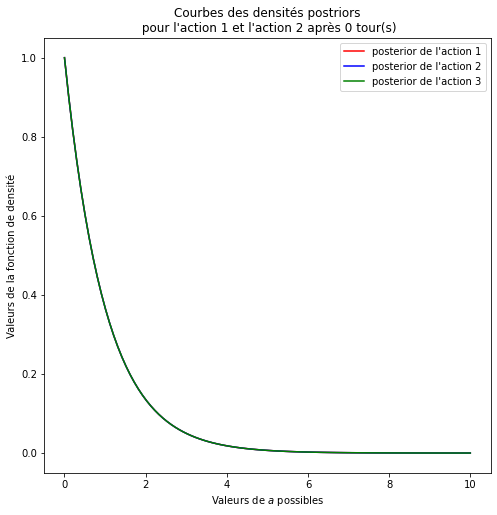

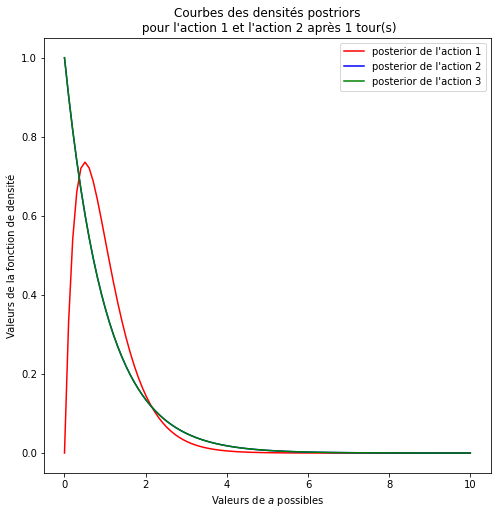

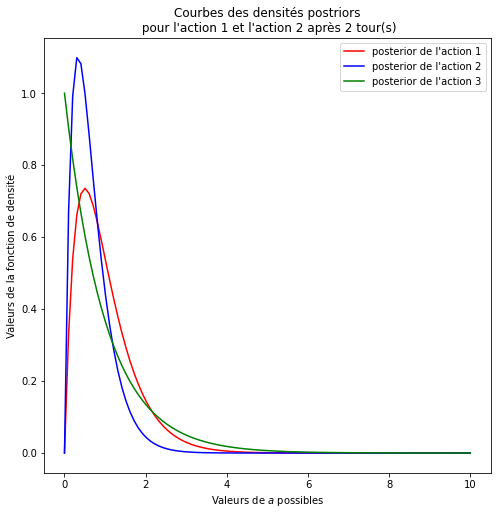

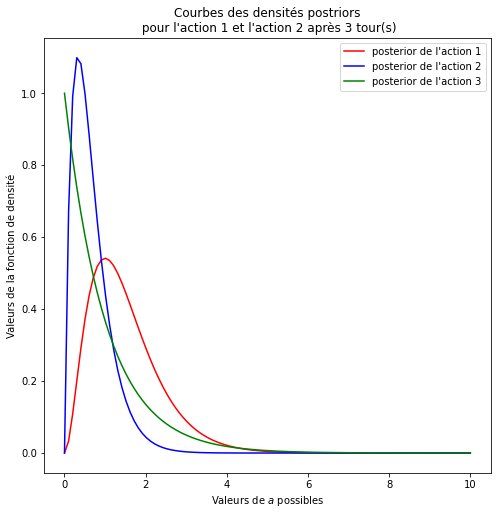

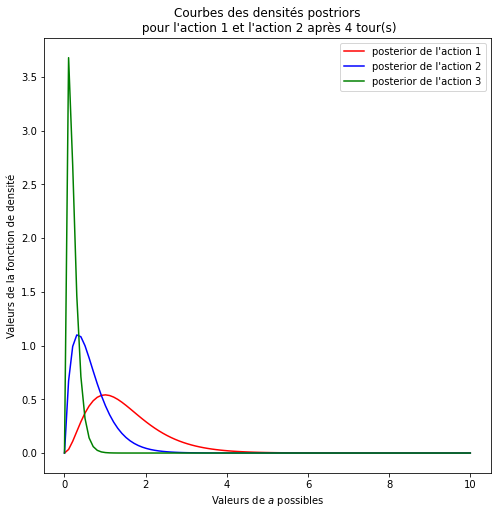

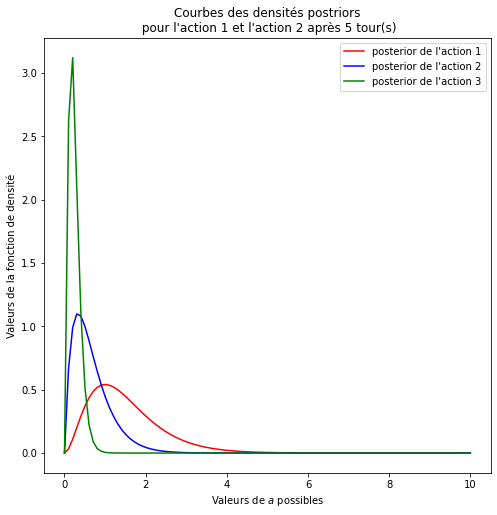

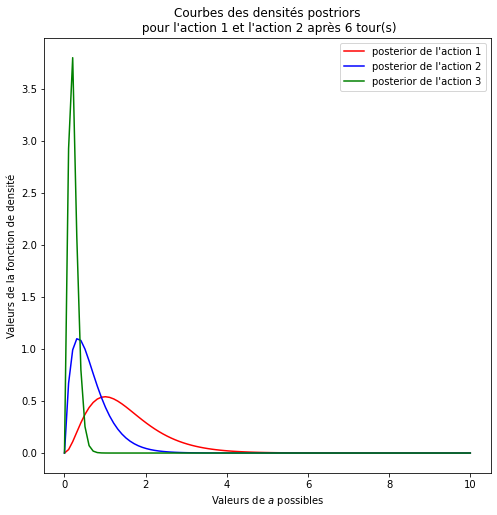

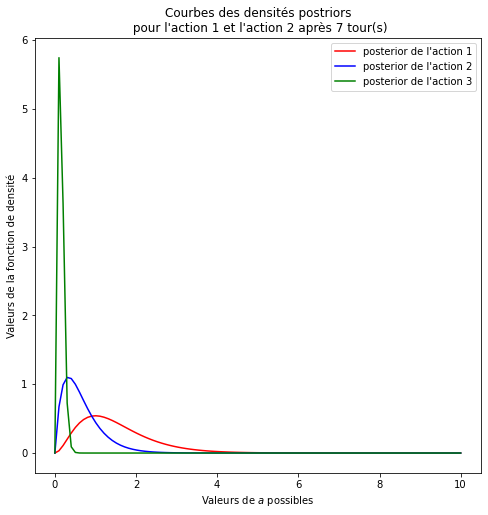

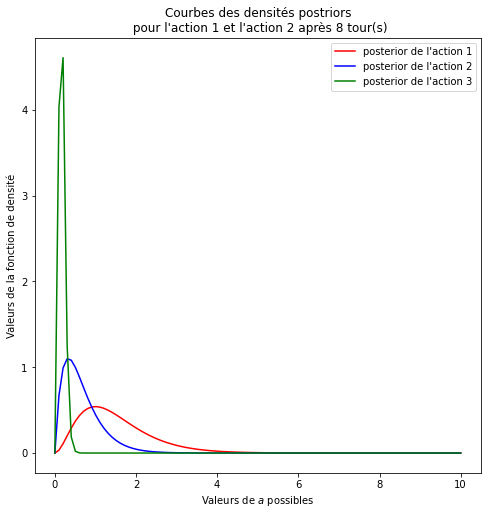

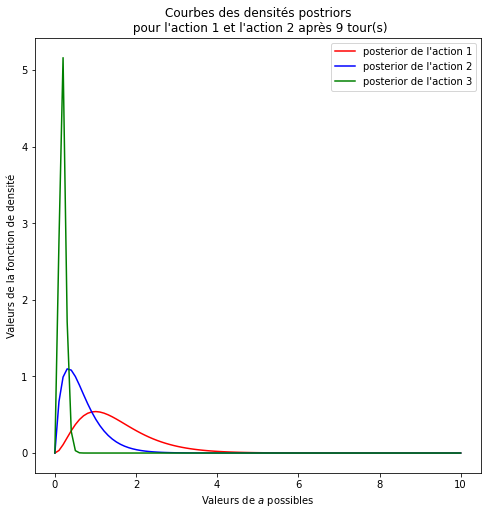

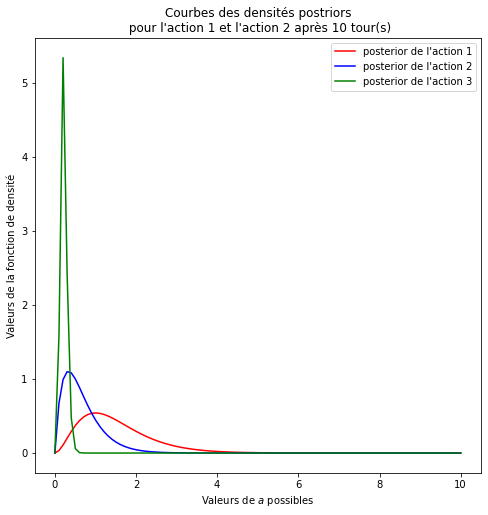

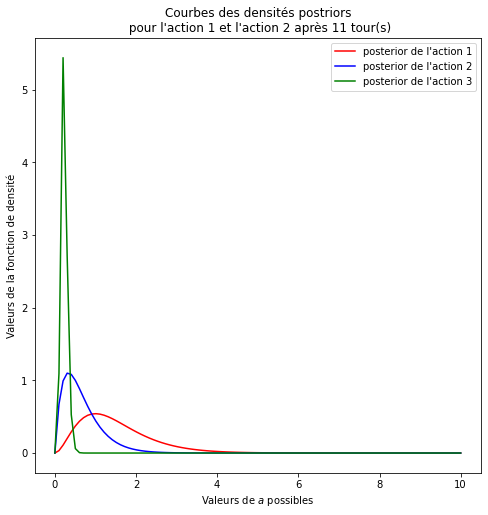

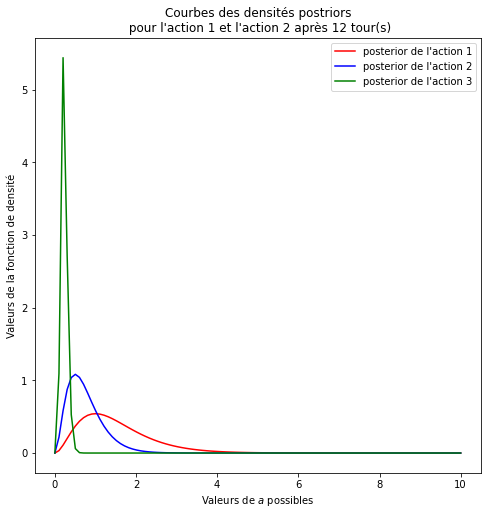

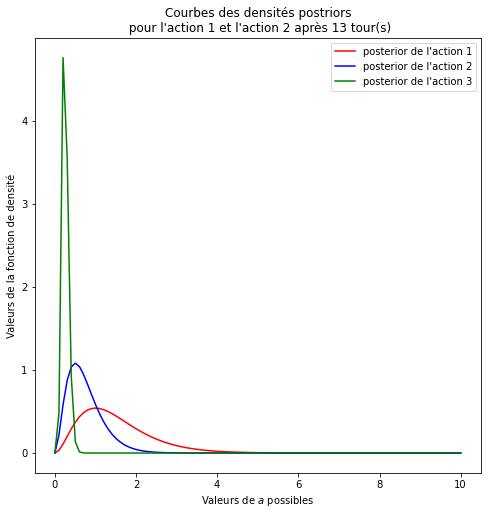

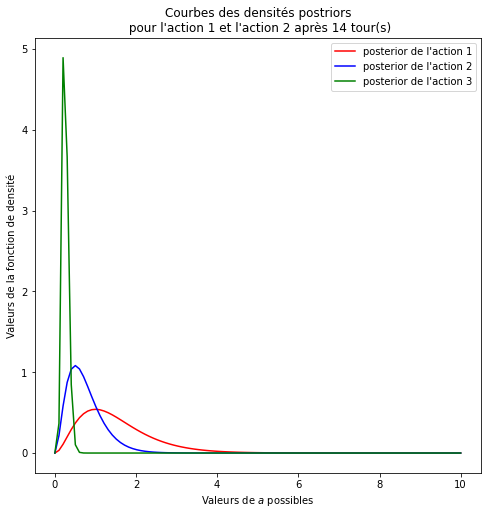

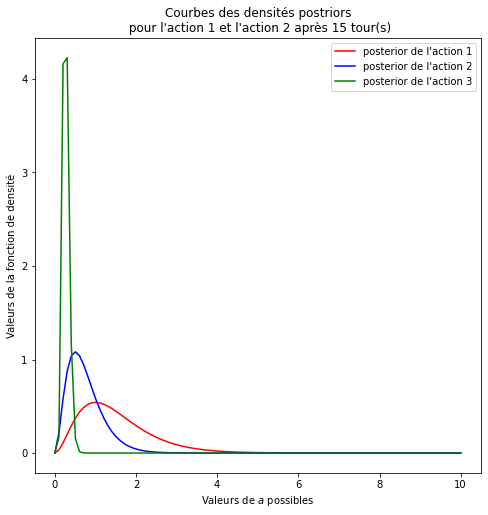

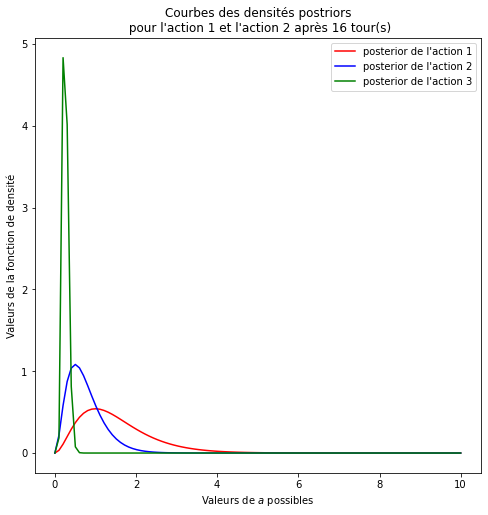

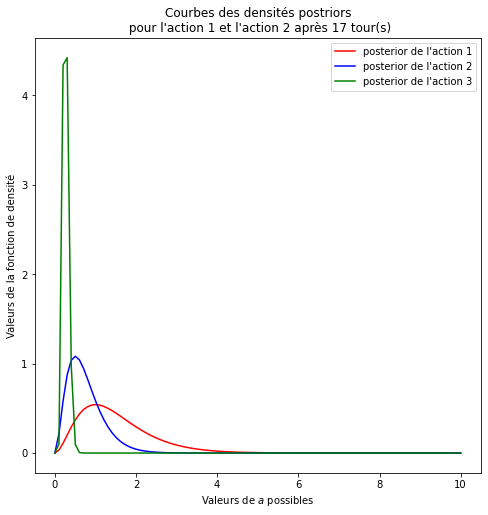

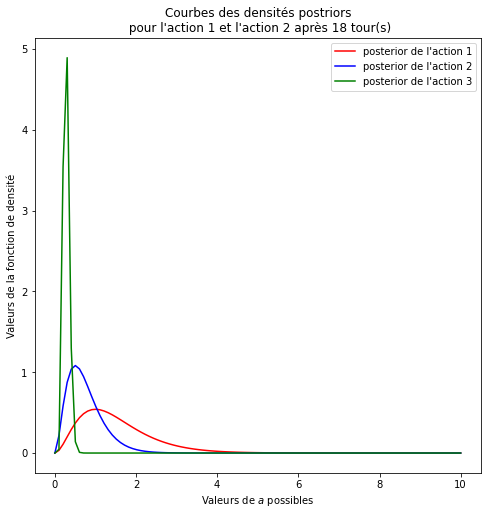

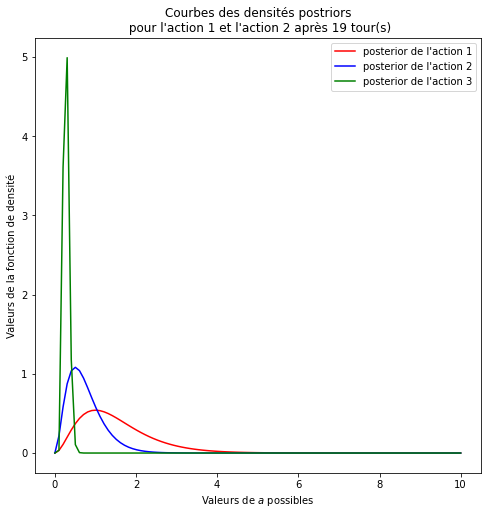

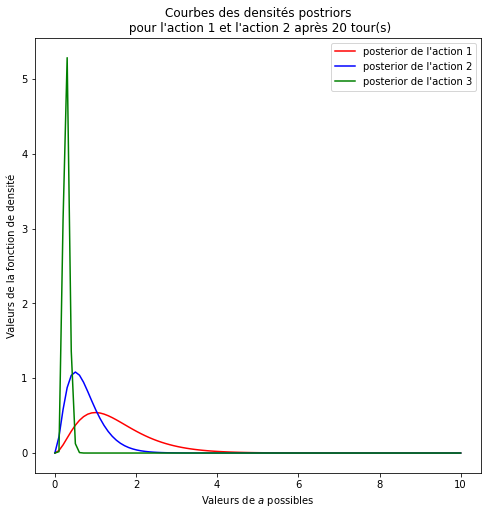

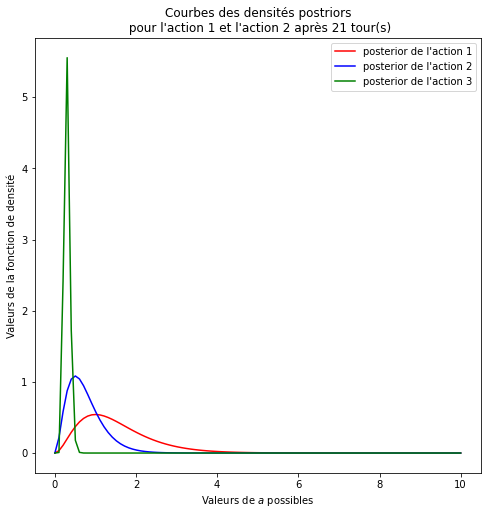

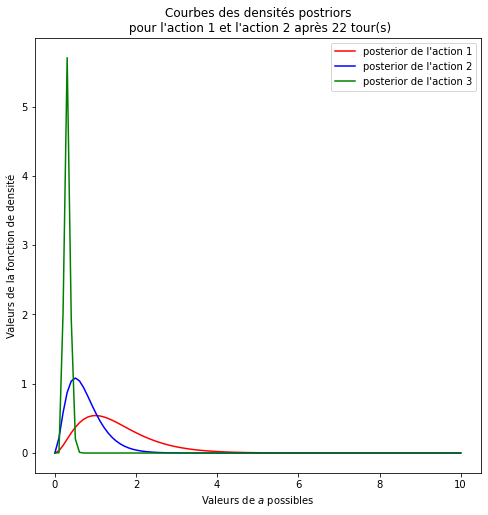

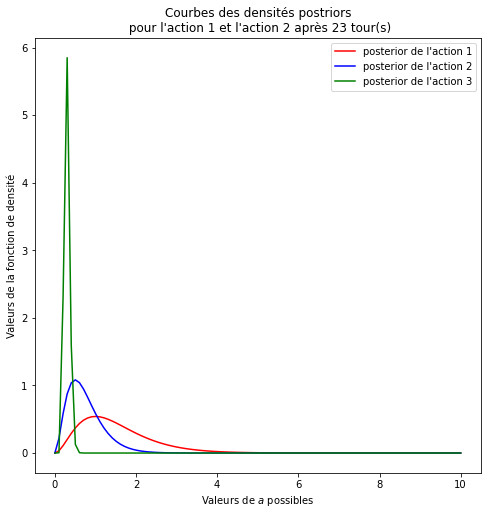

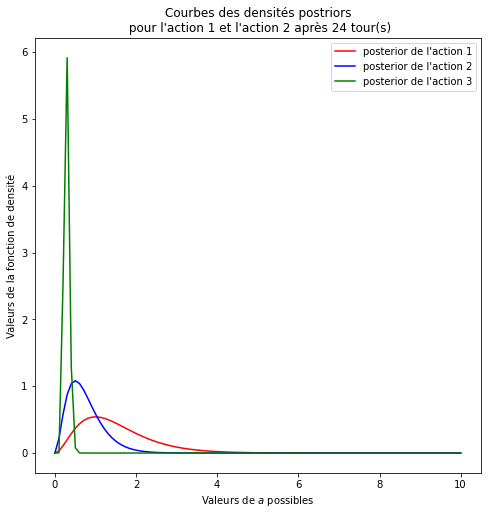

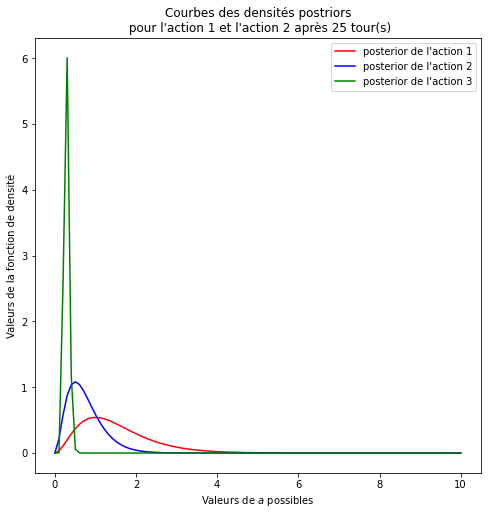

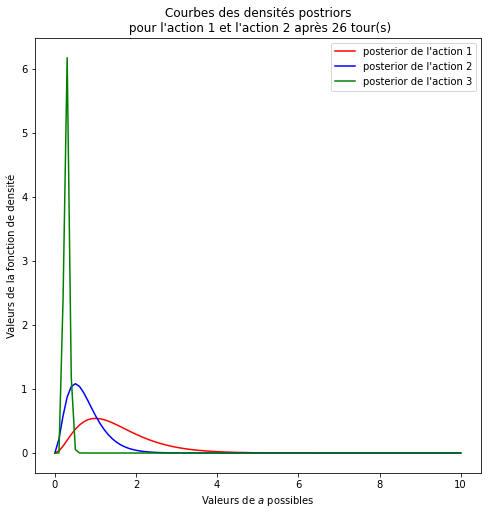

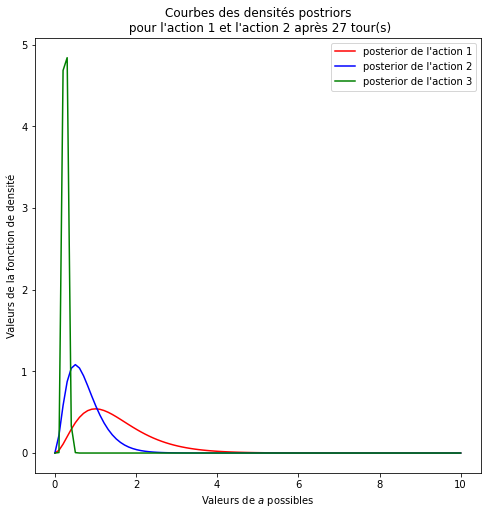

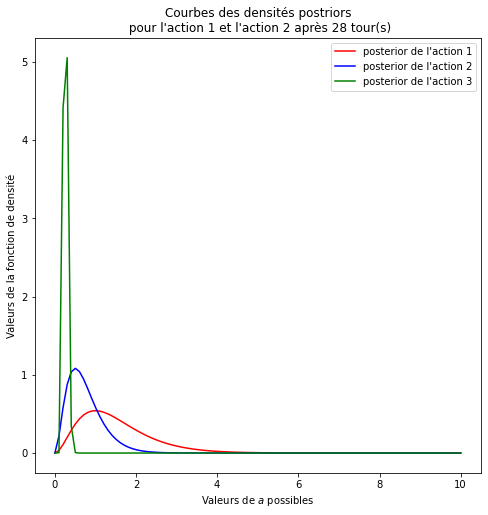

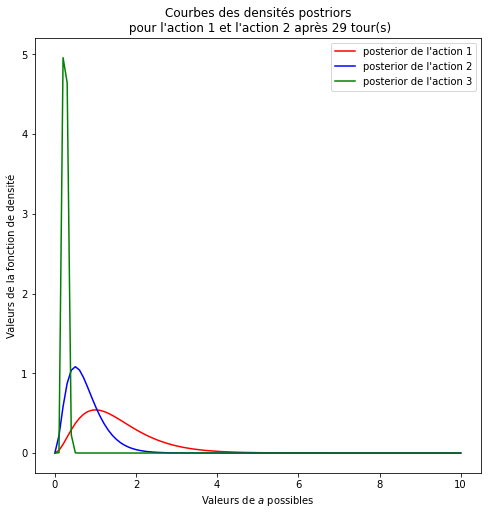

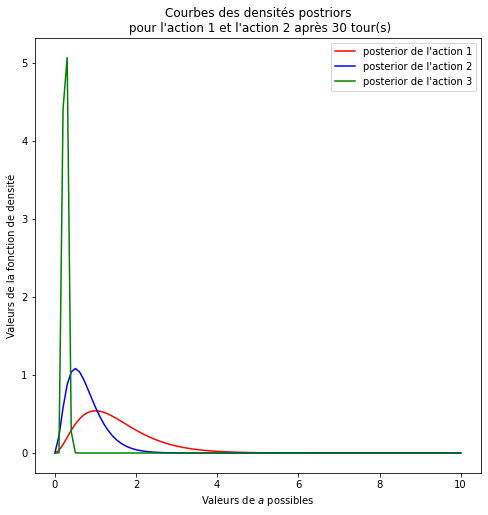

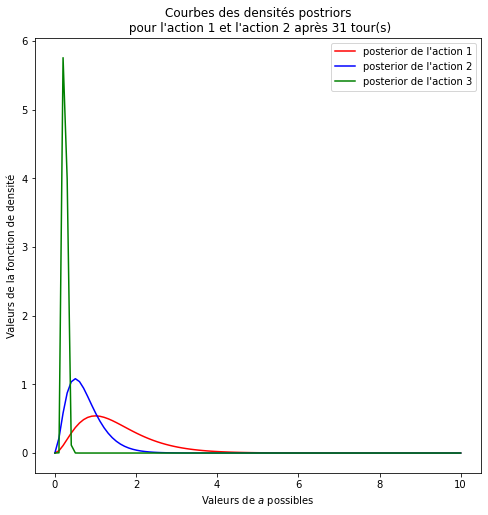

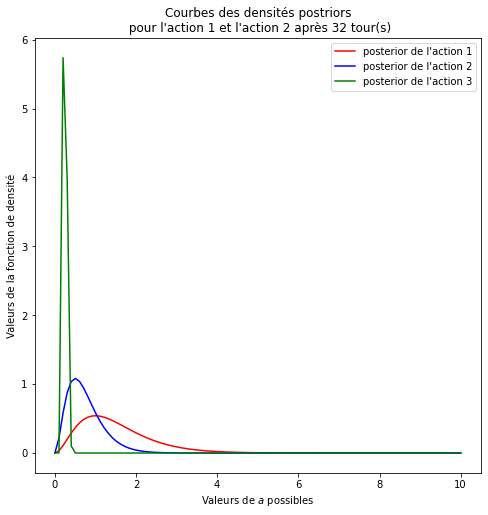

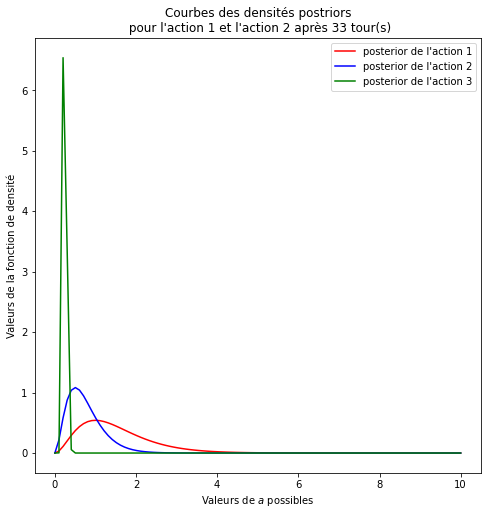

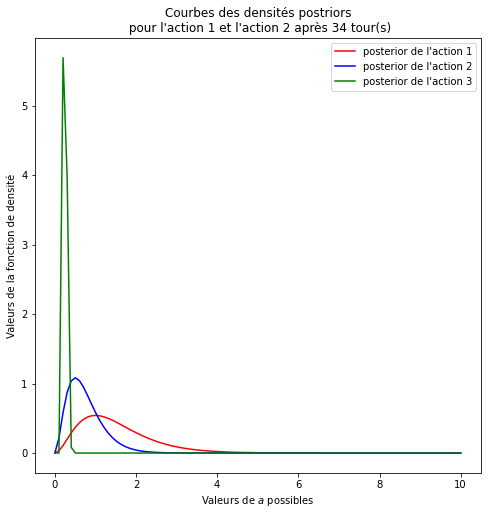

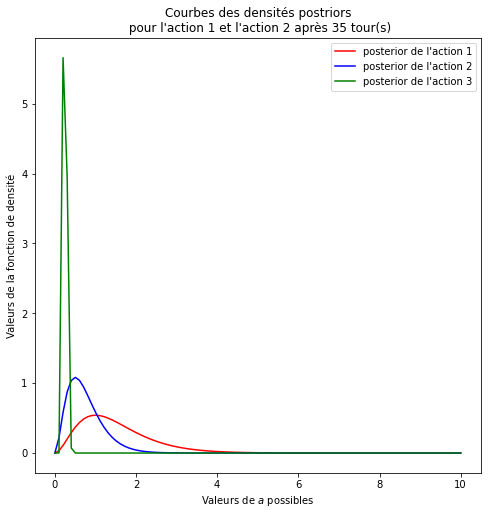

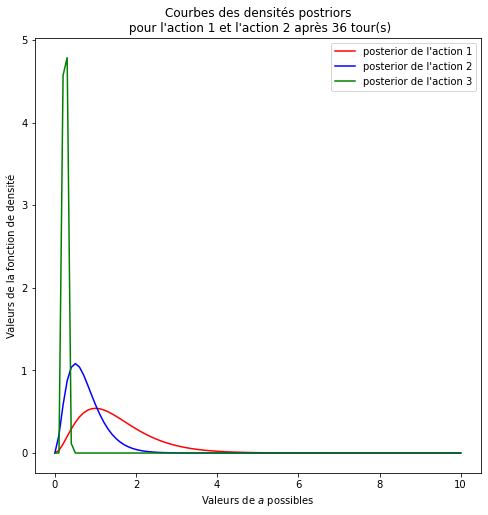

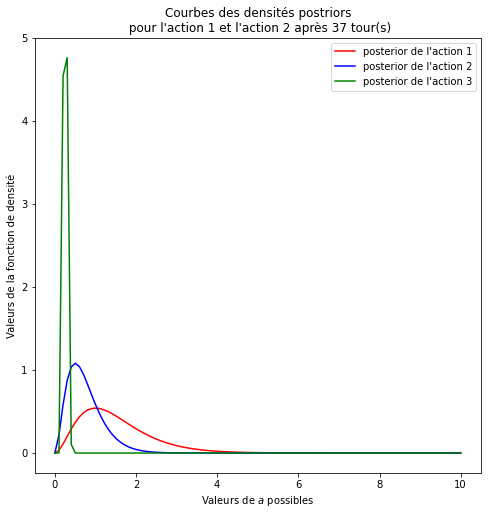

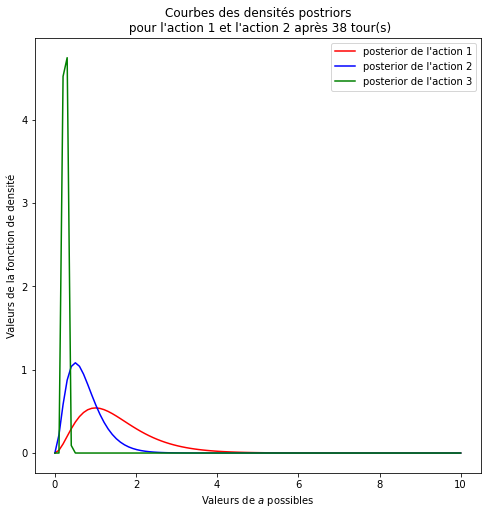

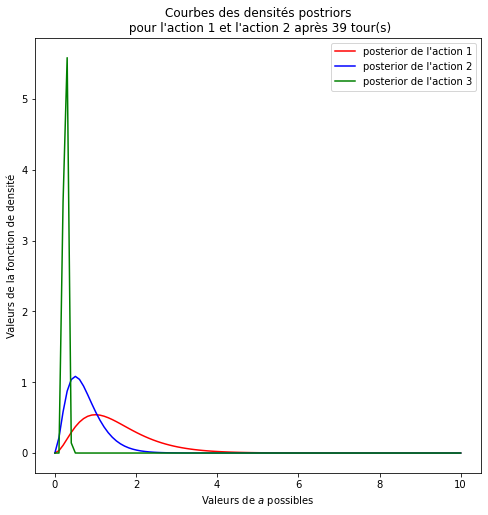

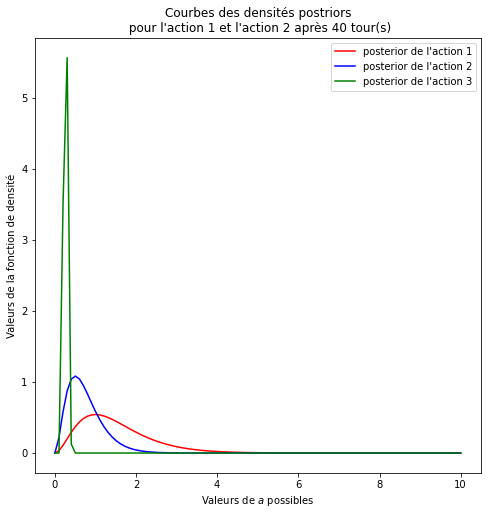

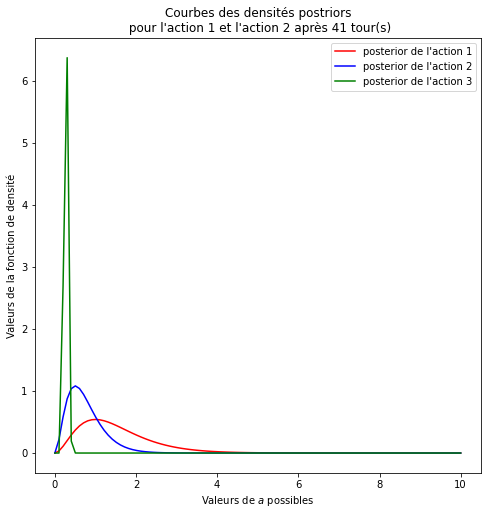

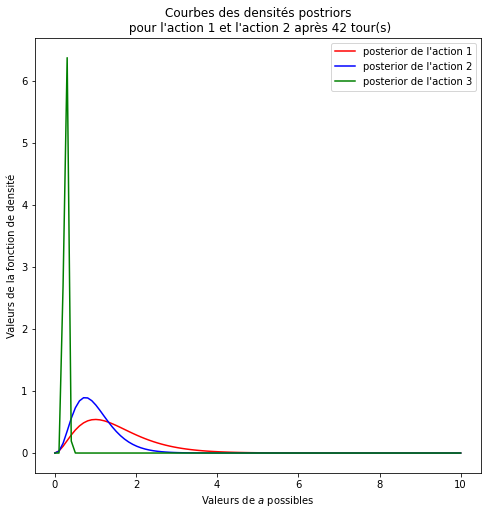

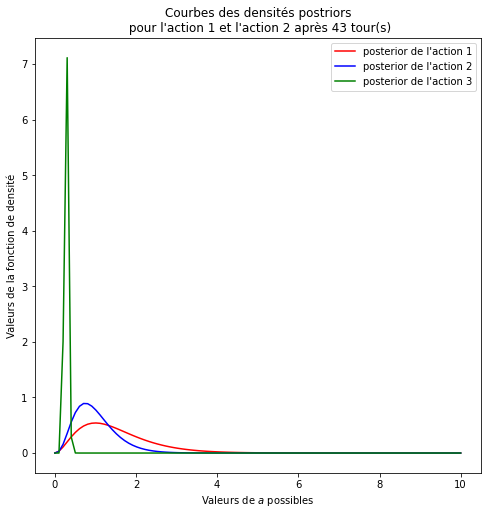

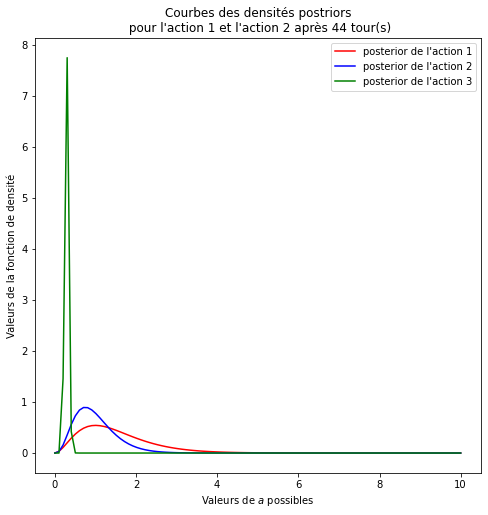

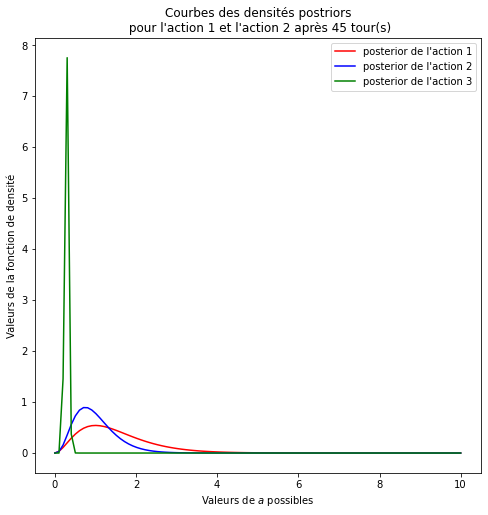

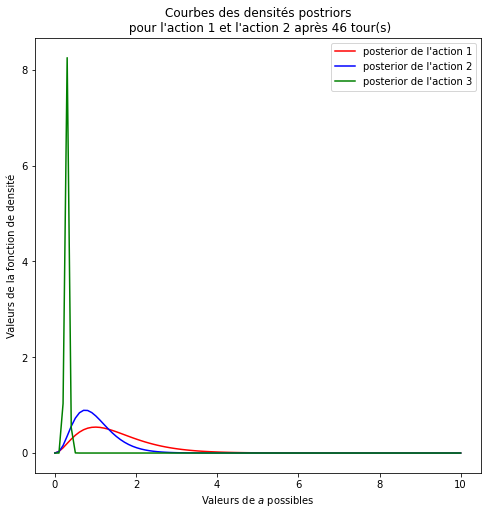

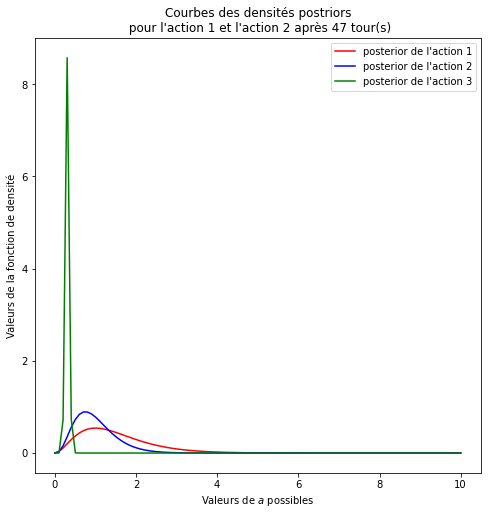

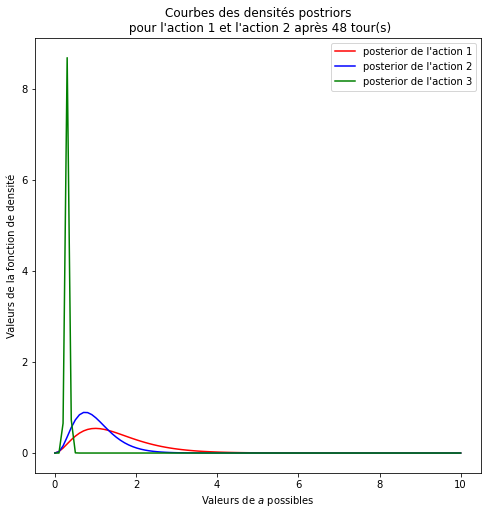

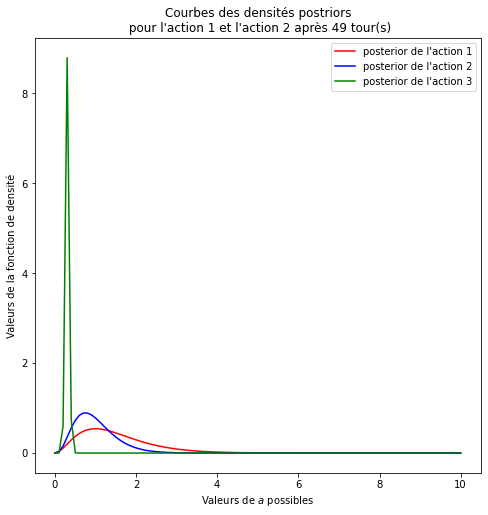

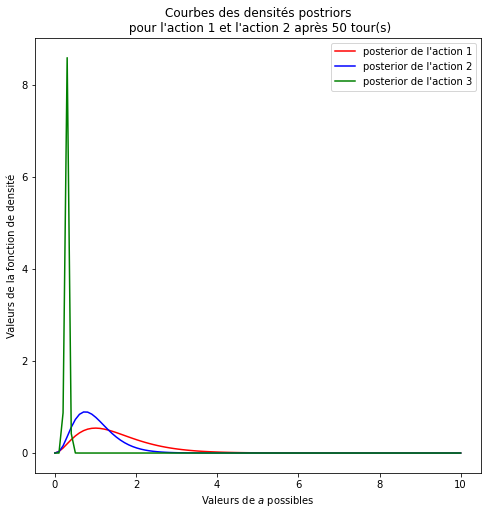

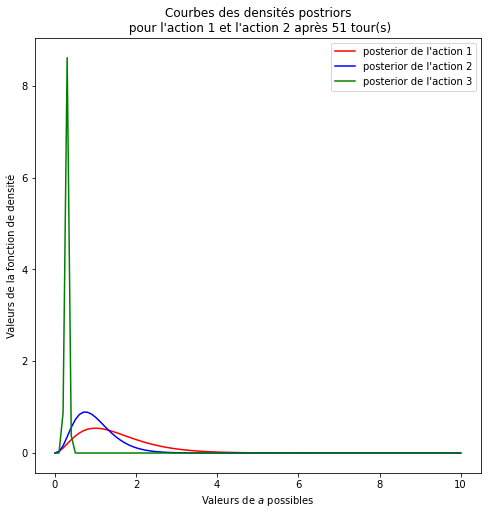

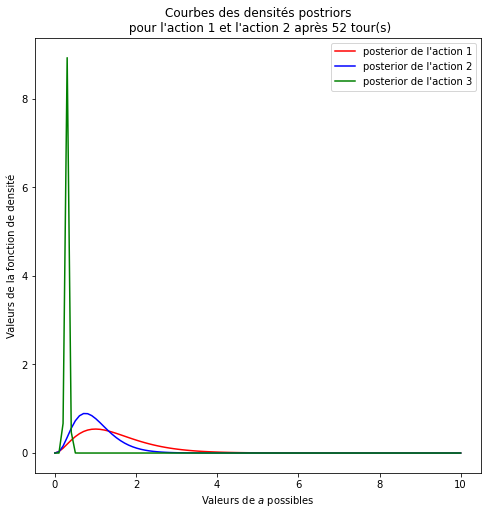

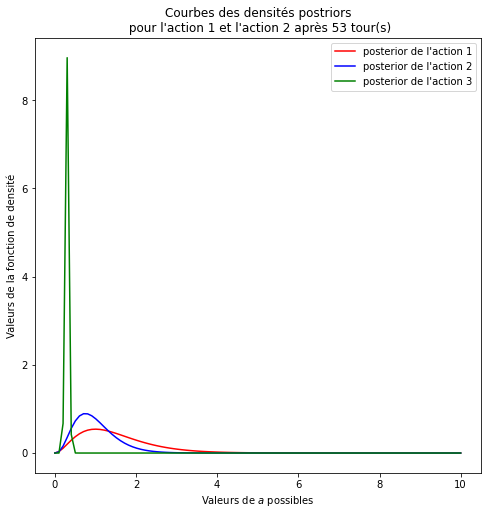

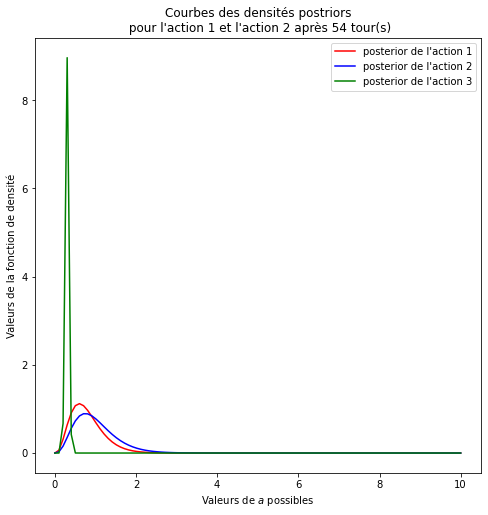

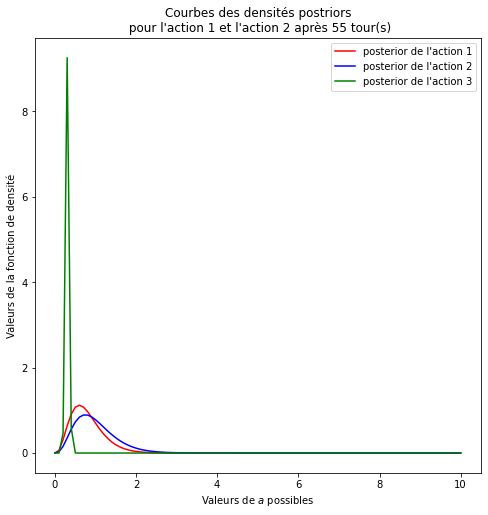

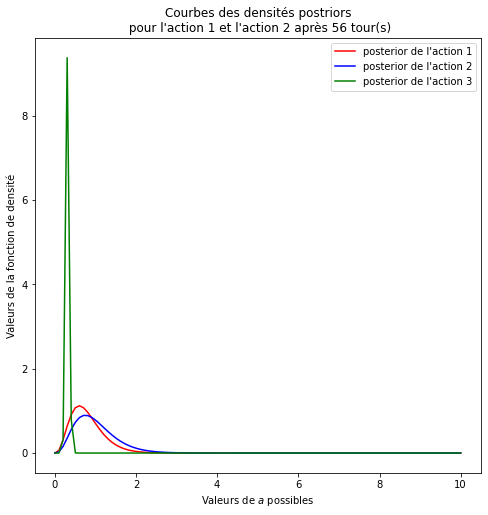

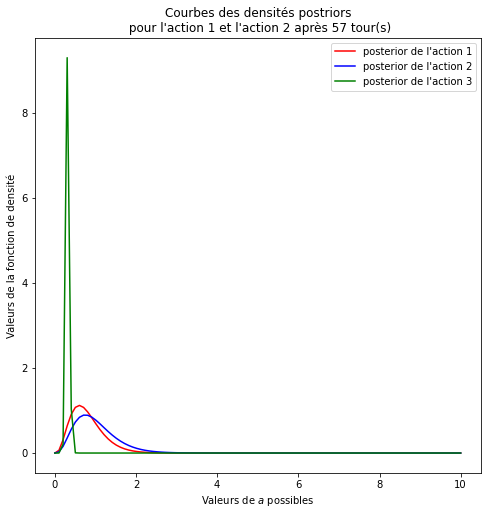

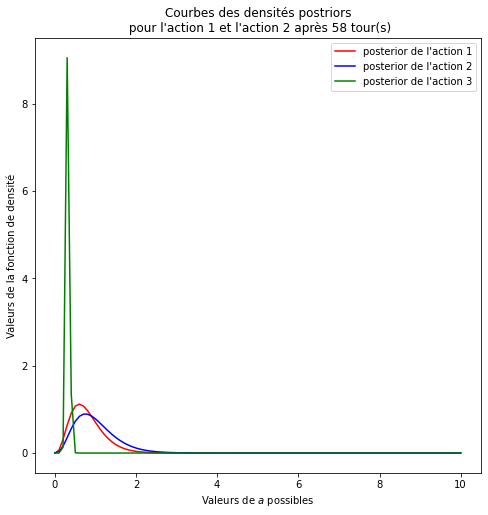

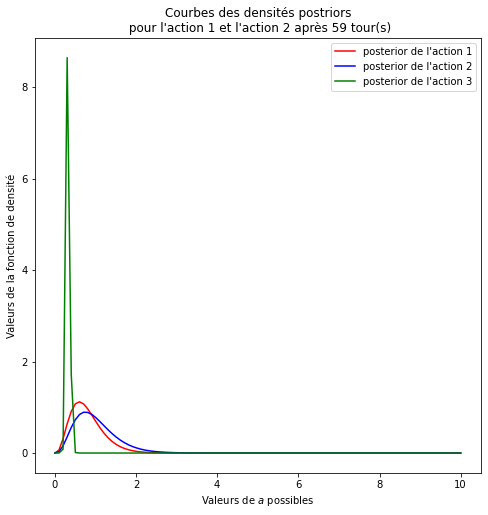

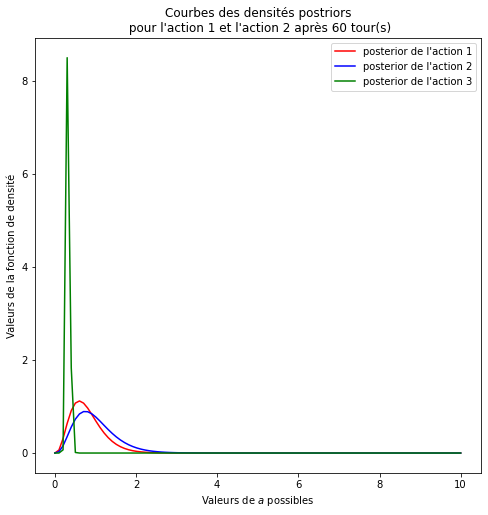

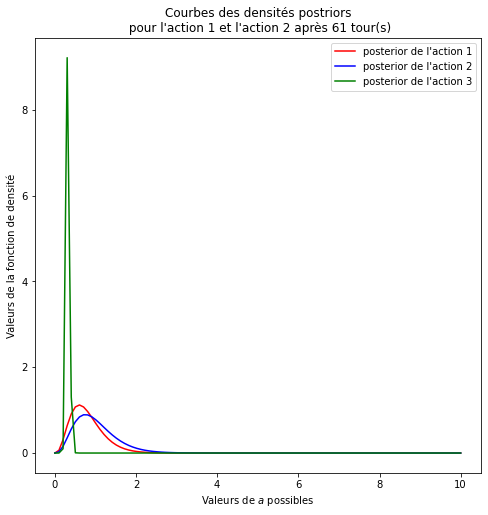

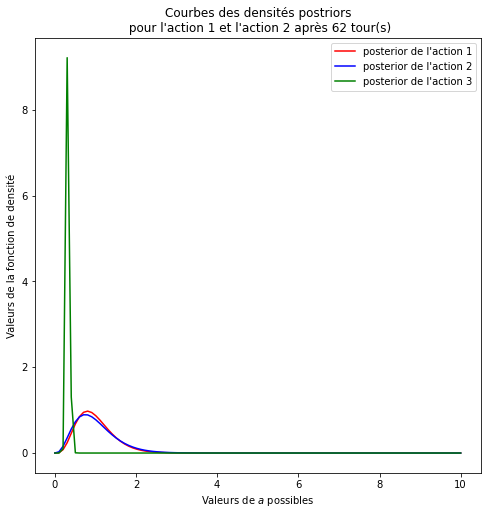

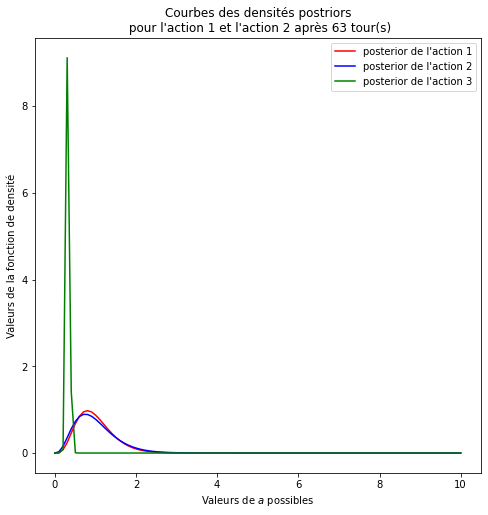

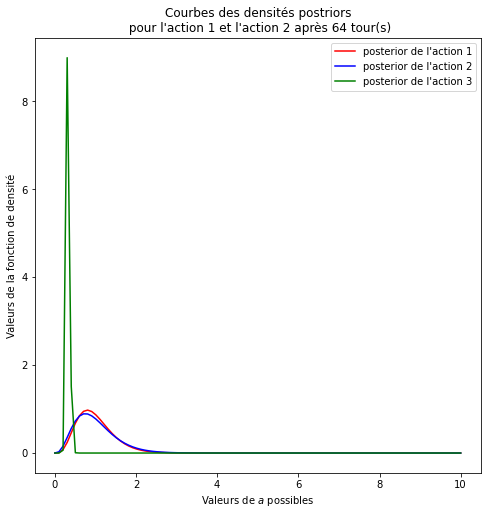

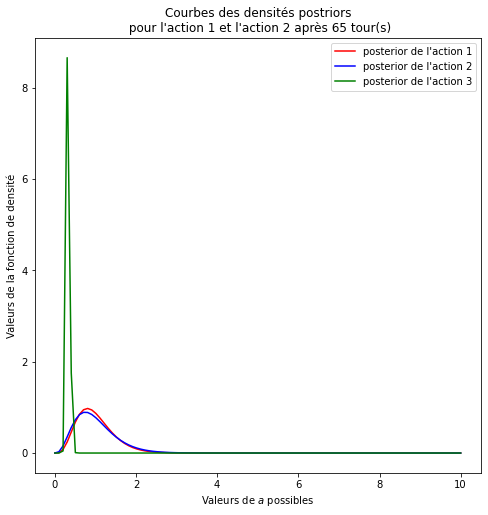

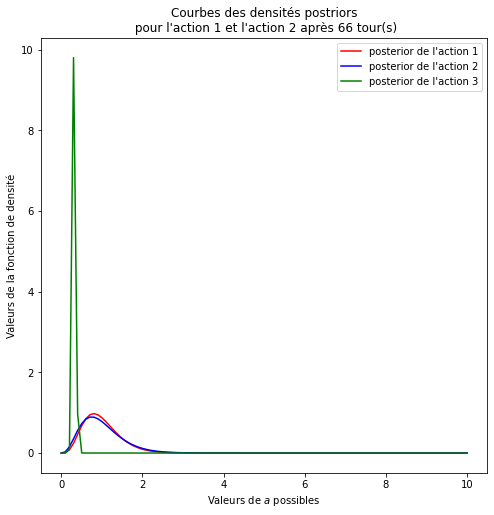

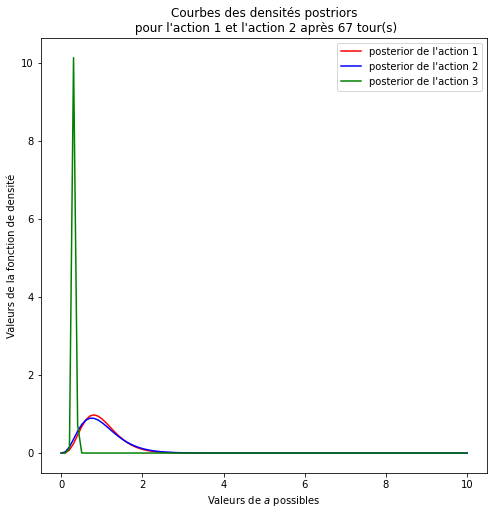

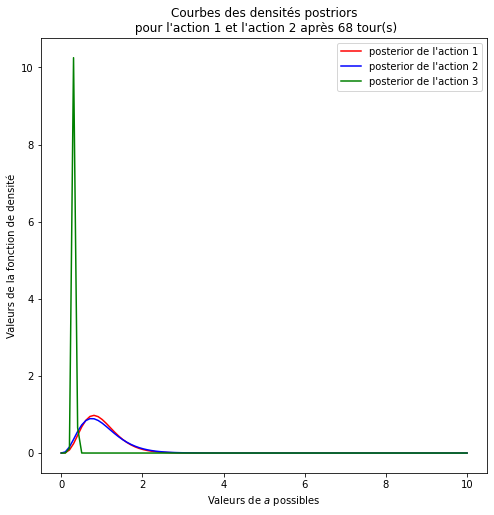

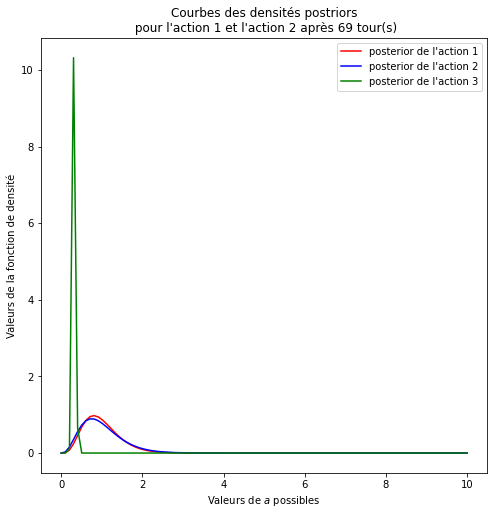

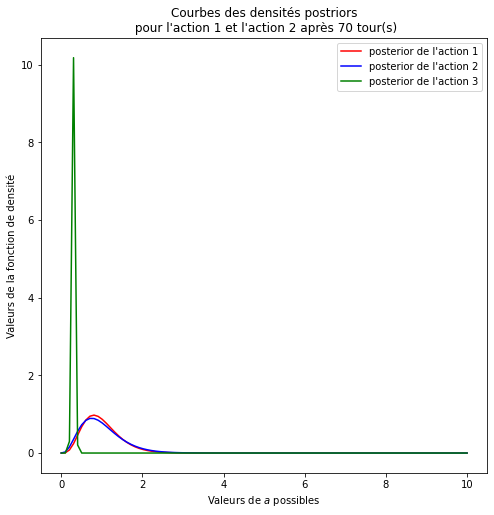

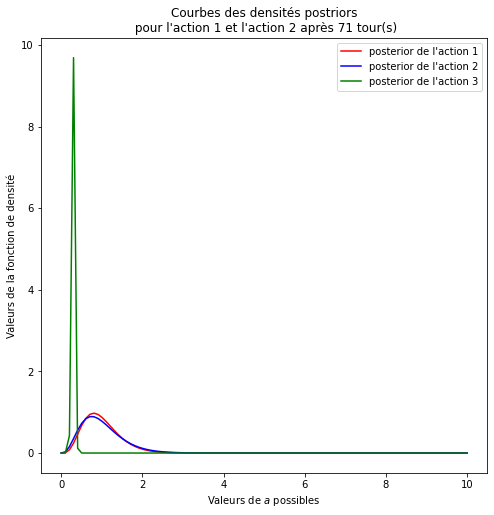

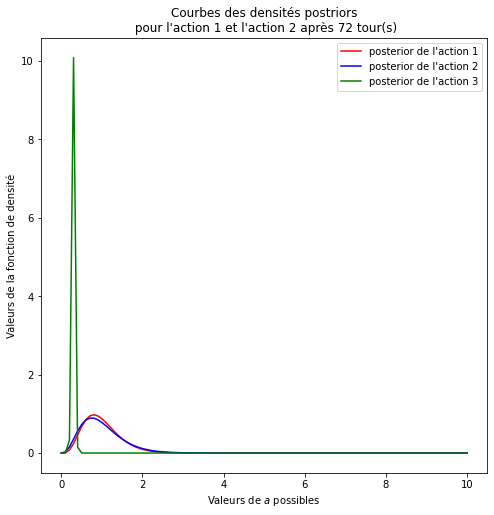

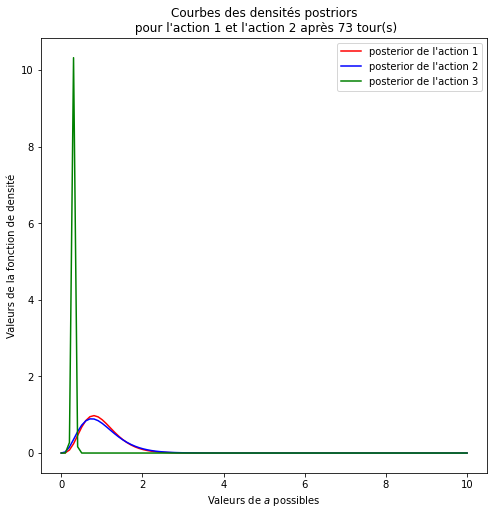

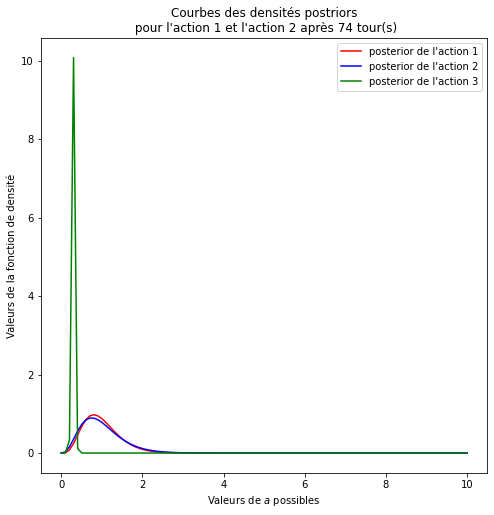

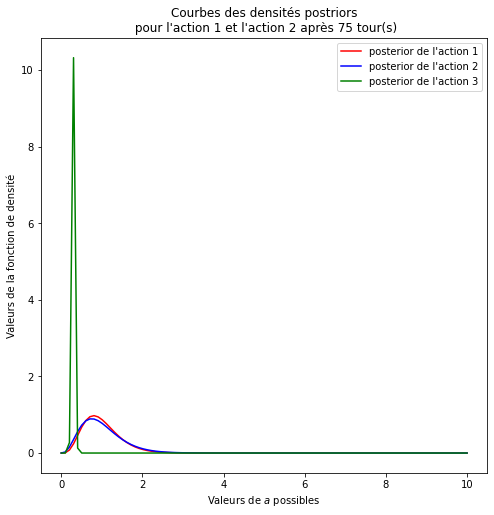

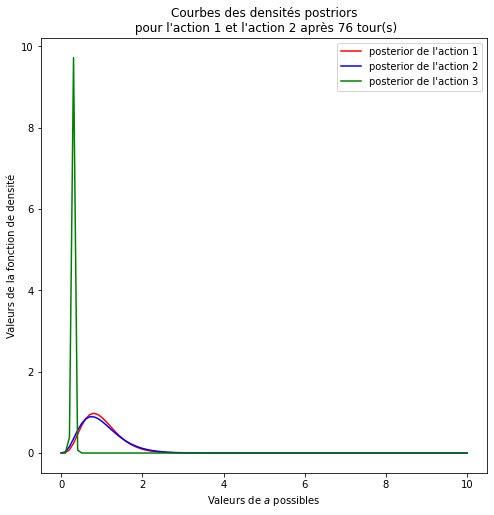

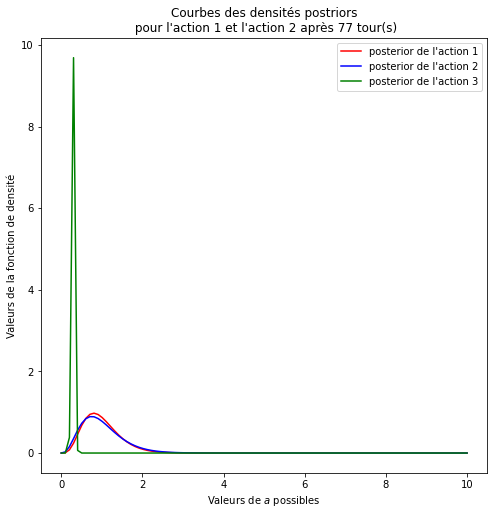

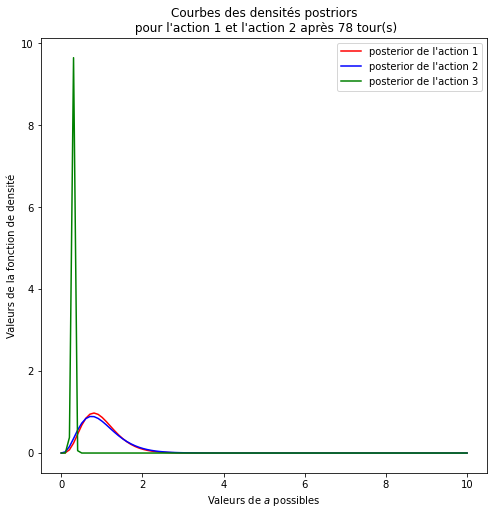

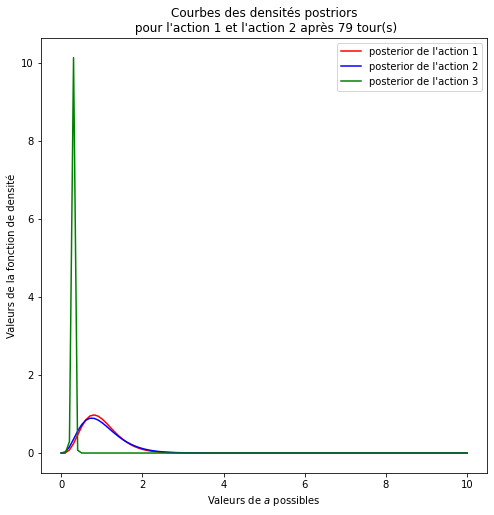

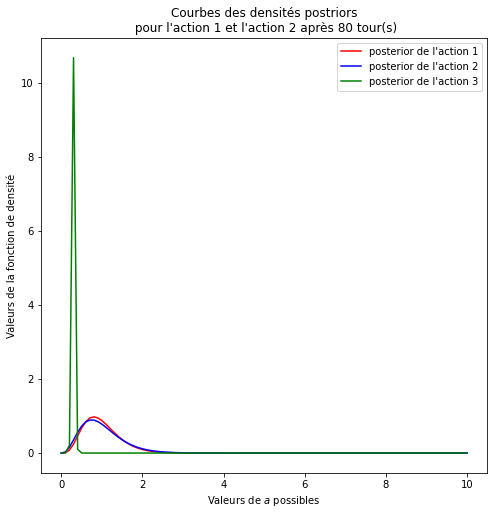

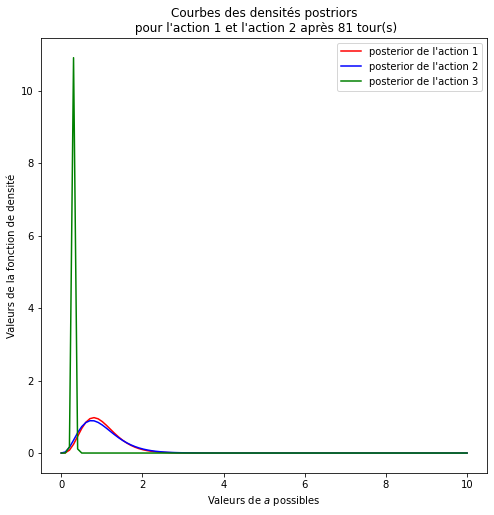

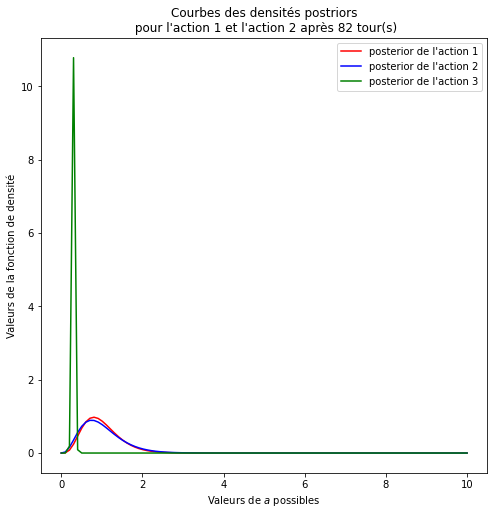

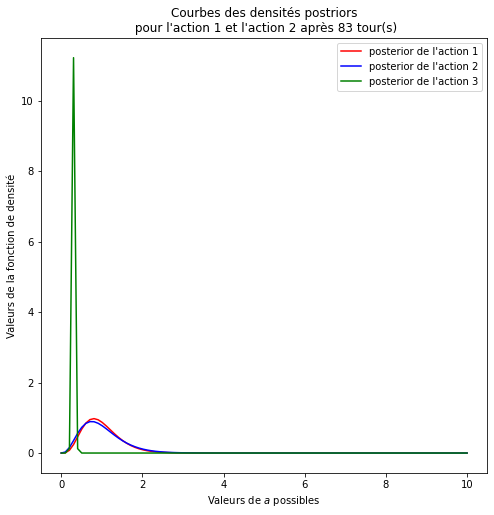

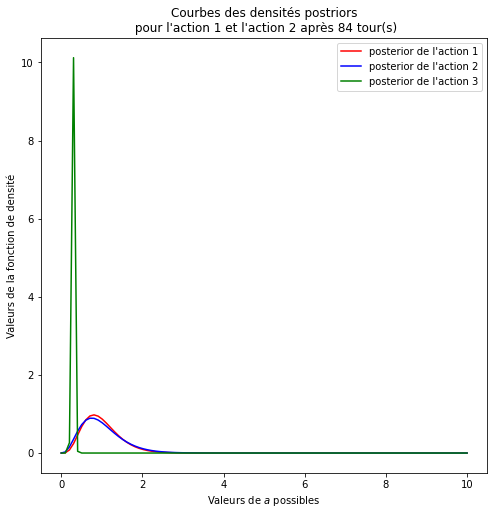

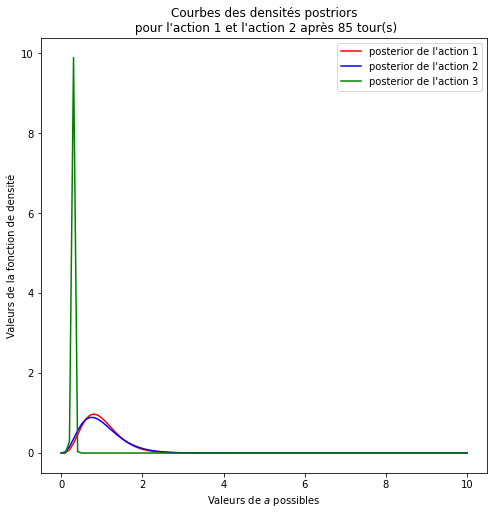

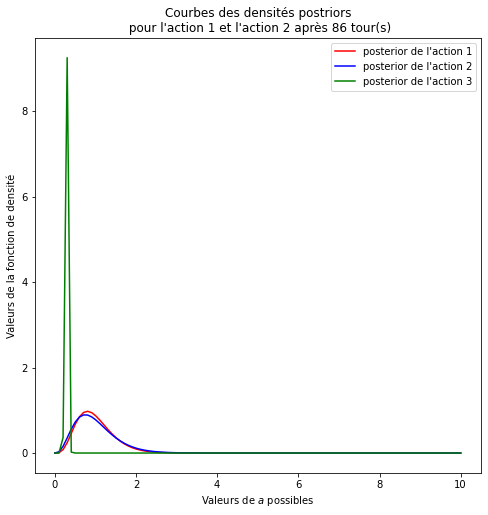

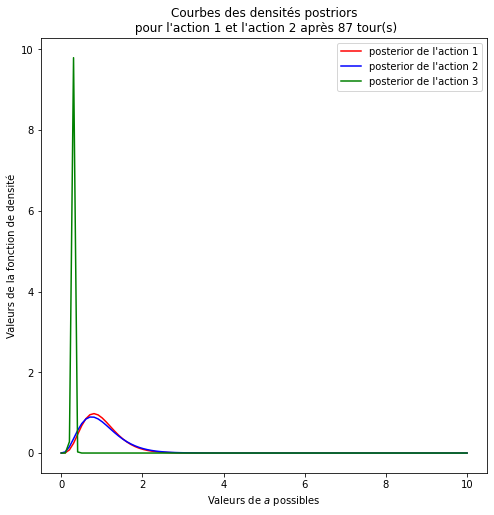

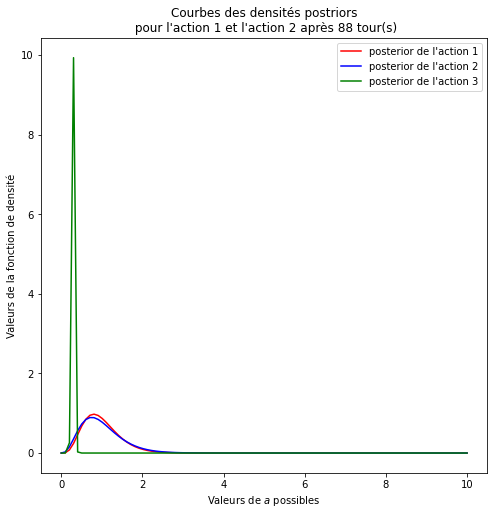

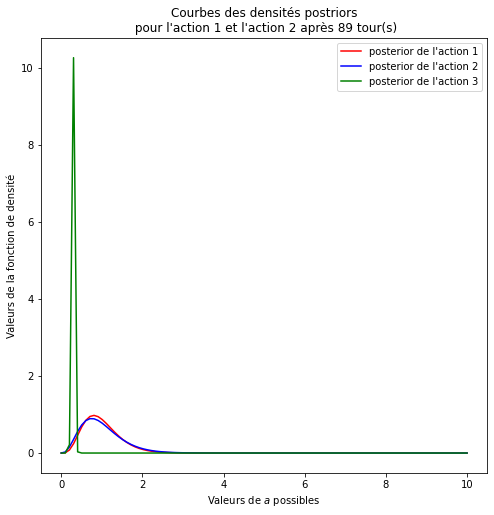

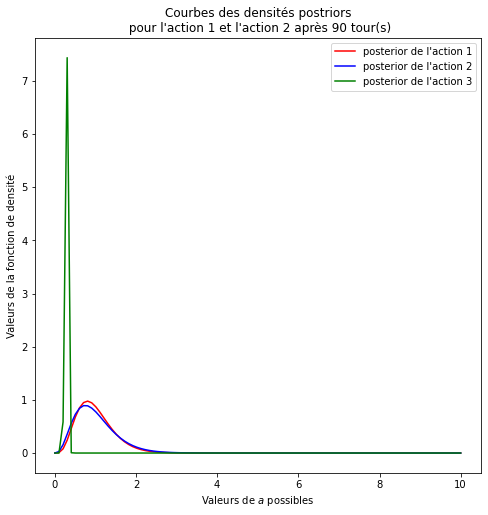

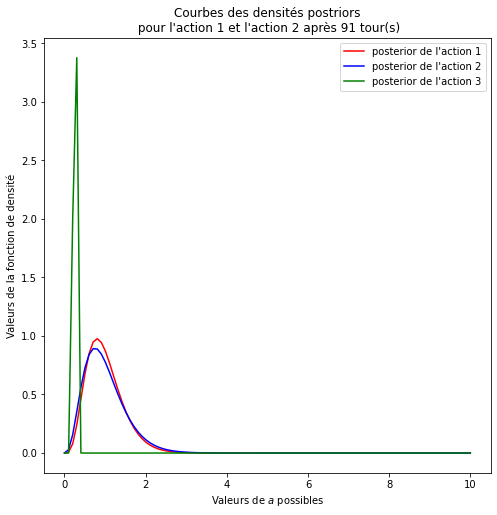

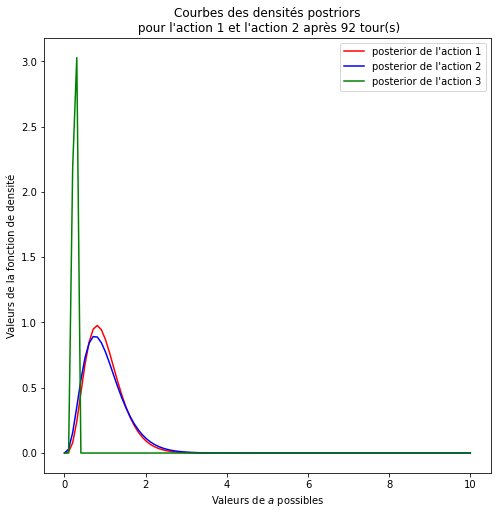

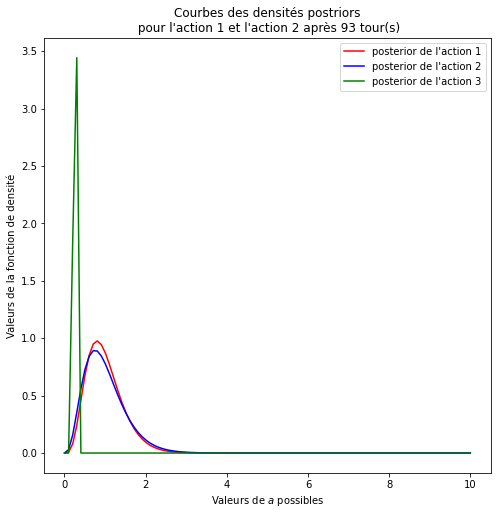

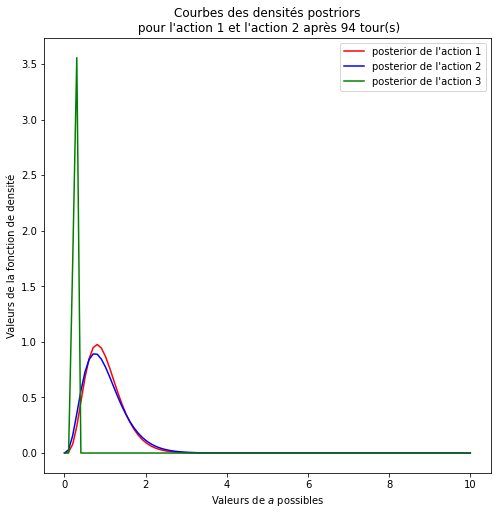

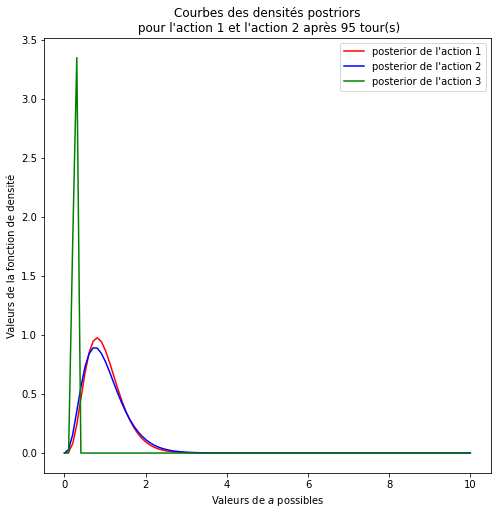

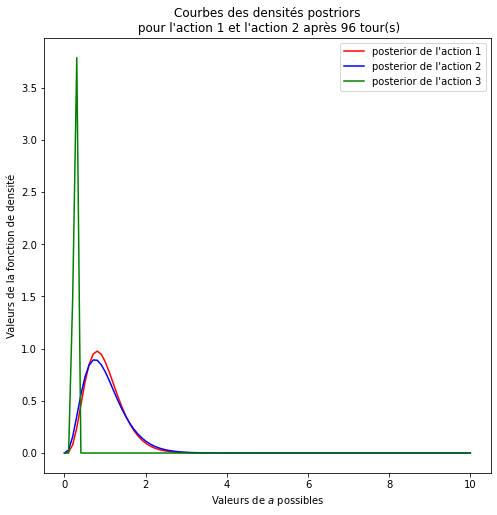

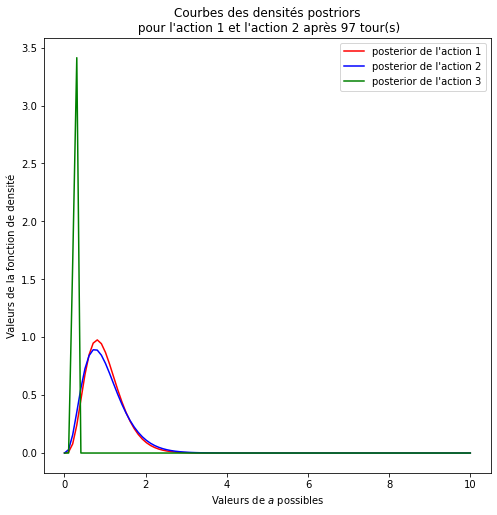

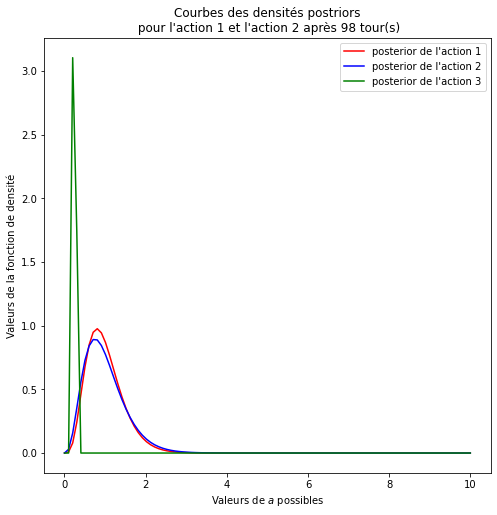

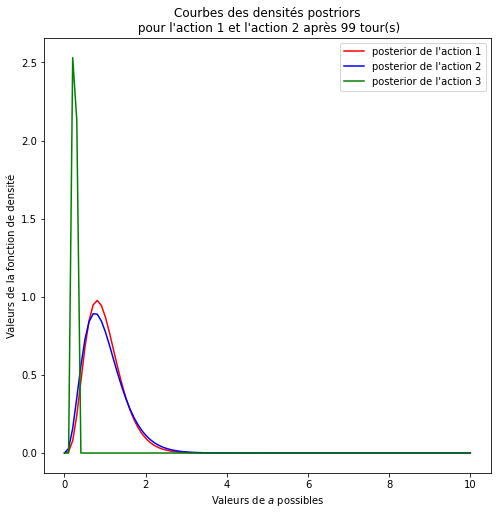

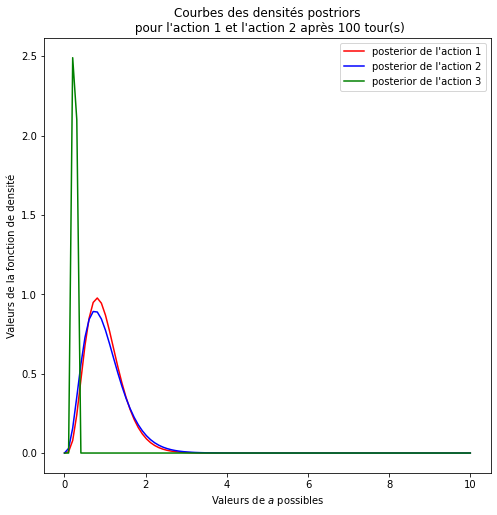

In [22]:
#Code pour tester l'algorithme Thompson Sampling pour des bandits à distributions de Pareto.
#On s'intéresse à un bandit à 2 bras avec x_m=1 et k_1 et k_2, k_3 variables
#Le code affiche les distributions posteriors à chacun des 100 tours.

x_m=np.array([1,1,1])
k=np.array([1,0.5,0.25])

banditest=ParetoBandit(x_m,k)

alpha, beta = 1, 1

T=100

al,be = ts_pareto(banditest,T,alpha,beta,seed=9,stock_alpha_beta=True, regret_method='scale')

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']

x=np.linspace(0,10,100)
for i in range(T+1):
    for m in range(len(k)):
        plt.plot(x,scipy.stats.gamma.pdf(x, al[m][i], scale=1/be[m][i]), color = colors[m],
             label="posterior de l'action {}".format(m+1))
        #plt.plot(x,scipy.stats.gamma.pdf(x, al[1][i], scale=1/be[1][i]), color ='blue',
        #     label="posterior de l'action 2")
    
    plt.xlabel('Valeurs de $a$ possibles')
    plt.ylabel('Valeurs de la fonction de densité')
    plt.title("Courbes des densités postriors\n pour l'action 1 et l'action 2 après {} tour(s)".format(i))
    
    plt.legend()
    plt.show()


In [24]:
def graphiques(x_m, k, moyennes_priors, variances_priors, T, titre, regret_method='location'):
    ''' Cette fonction crée le graphique permettant de comparer le pseudo regret cumulatif de l'algorithme Thompson Sampling 
    sur des bras à distribution de Pareto selon les moyennes et variances des distributions gamma des priors. 
    Entrées: 
    les moyennes (means) des différentes instances de PoissonBandit sur lequel les algorithmes font tester.
    les moyennes (moyennes_priors) et variances (variances_priors) sur les priors à tester.
    T: L'horizon sur lequel le test se fait
    title: string représentant le titre du graphique à produite
    '''
    N = k.shape[0] #Donne le nombre d'instances
    n = len(moyennes_priors) #Donne le nombre de tests (priors différents à tester) 
    
    alpha = (moyennes_priors**2)/(variances_priors) #Contient les alpha des différentes priors à tester
    beta = (moyennes_priors)/(variances_priors)     #Contient les beta des différentes priors à tester
    
    cum_regrets=[]
    for i in range(n):
        cum_regrets.append([])
    #cum_regrets contient une liste de n listes prêtes à contenir les regrets cumulatifs pour chacun des tests.
    
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']
    
    for i in range(n):
        
        #i donne le numéro de la prior à utiliser
        
        for j in range(N):
            
            banditest = ParetoBandit(x_m[j,],k[j,],seed=j, regret_method=regret_method)
            ts_pareto(banditest, T, alpha=alpha[i], beta=beta[i], seed=j, regret_method=regret_method)
            cum_regrets[i].append(banditest.get_cumulative_regret())
            
        cum_regrets_moy = np.apply_along_axis(np.mean, 0, cum_regrets[i])
        cum_regrets_sd = np.apply_along_axis(np.std, 0, cum_regrets[i])
        
        plt.plot(range(T), cum_regrets_moy, color=colors[i],
        label = r'$\alpha_0$ = {}, $\beta_0$ = {},  $\mu_0$ = {}, $\sigma^2_0$ = {}'.format(alpha[i],beta[i], moyennes[i],variances[i]))
        plt.plot(range(T), cum_regrets_moy + cum_regrets_sd, color = colors[i], linestyle='dashed')
    
    plt.xlabel('Pas de temps')
    plt.ylabel('Pseudo regret cumulatif moyen')
    plt.title(titre)
    lgd=plt.legend(bbox_to_anchor=(1.05, 1))
        
    ##Ne pas décommenter, c'est seulement pour gérer le sauvegarde des figures dans un fichier
    #plt.savefig("variance_trop_petites_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("variance_trop_grande_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_bonne_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_petite_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

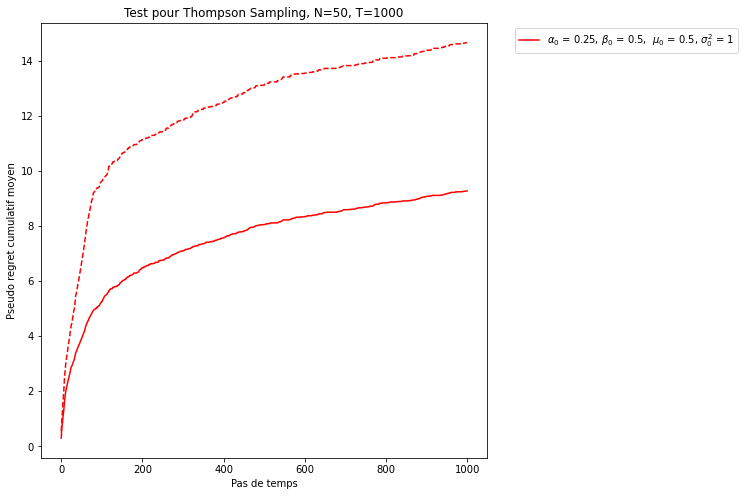

In [28]:
generation=np.random.RandomState(10)

N, T = 50 ,1000

k=np.array([[1,0.5],]*N)
L=np.array([[1,1],]*N)


moyennes = np.array([0.5])
variances = np.array([1])

titre='Test pour Thompson Sampling, N={}, T={}'.format(N,T)

graphiques(L, k, moyennes, variances, T, titre, regret_method='scale')

C:\Users\Utilisateur\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6089: RuntimeWarning: overflow encountered in power
  return pow(1-q, -1.0/b)


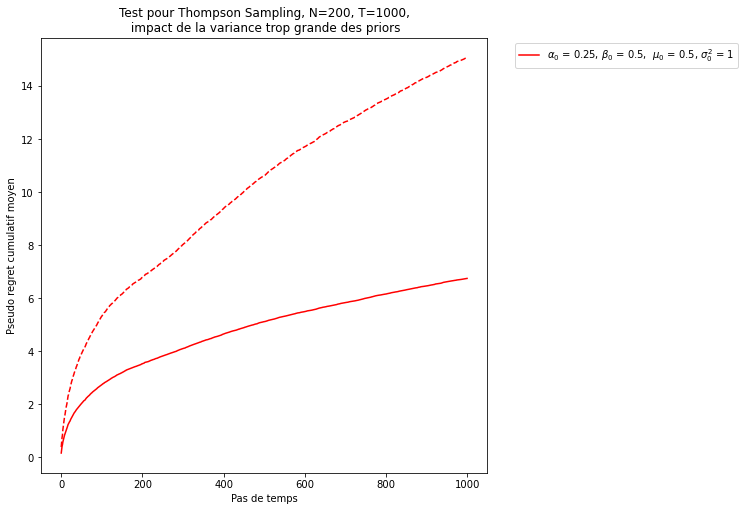

In [29]:
# On génère ici N instances de bandits à deux bras à distribution de Poissons avec les moyennes choisient 
# uniformément dans l'intervalle[0,10]

generation=np.random.RandomState(10)

N, T = 200, 1000

k = generation.rand(N,2)

L = np.array([[1,1],]*N)

#Expérience sur des variances trop grandes

#on teste des priors différents (ici la moyenne est toujours de 5 (centre de l'intervalle))
#test de l'effet d'une variance trop grande 

moyennes = np.array([0.5])
variances = np.array([1])

titre='Test pour Thompson Sampling, N={}, T={},\n impact de la variance trop grande des priors'.format(N,T)

graphiques(L, k, moyennes, variances, T, titre, regret_method='scale')